In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from warnings import filterwarnings
filterwarnings(action='ignore')

# Thinkful Curriculum Section

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club (2015) to predict the state of a loan given some information about it. You can download the dataset [here](https://www.dropbox.com/s/0so14yudedjmm5m/LoanStats3d.csv?dl=1)

In [2]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv(
    '/Users/megandibble/Desktop/Thinkful Jupyter Notebooks/Assignments/LoanStats3d.csv',
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

In [3]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical column and see what happens off of this kind of naive approach.

In [4]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#rfc = ensemble.RandomForestClassifier()
#X = y2015.drop('loan_status', 1)
#Y = y2015['loan_status']
#X = pd.get_dummies(X)

#cross_val_score(rfc, X, Y, cv=5)

Did your kernel die? My kernel died.

Guess it isn't always going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!)

## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [5]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
421097
term
2
int_rate
110
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
1
url
421095
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
25
next_pymnt_d
4
last_credit_pull_d
26
application_type
2
verification_status_joint
3


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [6]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [7]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,0.0,3.0,100.0,50.0,1.0,0.0,51239.0,34178.0,10600.0,33239.0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,1.0,2.0,95.0,66.7,0.0,0.0,96919.0,58418.0,9700.0,69919.0
421094,36271262.0,38982659.0,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,0.0,1.0,100.0,50.0,0.0,1.0,43740.0,33307.0,41700.0,0.0
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

Now this should be better. Let's try again.

In [9]:
pd.get_dummies(y2015)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,application_type_INDIVIDUAL,application_type_JOINT,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,14.85,379.39,48000.0,33.18,0.0,...,0,0,0,0,0,1,0,0,0,0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,7.49,298.58,60000.0,22.44,0.0,...,0,0,0,0,0,1,0,0,0,0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,7.49,777.55,109000.0,26.02,0.0,...,0,0,0,0,0,1,0,0,0,0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,6.49,858.05,92000.0,21.60,0.0,...,0,0,0,0,0,1,0,0,0,0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,19.89,320.99,55000.0,25.49,0.0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421090,36371250.0,39102635.0,10000.0,10000.0,10000.0,11.99,332.10,31000.0,28.69,0.0,...,0,0,0,0,0,1,0,0,0,0
421091,36441262.0,39152692.0,24000.0,24000.0,24000.0,11.99,797.03,79000.0,3.90,0.0,...,0,0,0,0,0,1,0,0,0,0
421092,36271333.0,38982739.0,13000.0,13000.0,13000.0,15.99,316.07,35000.0,30.90,0.0,...,0,0,0,0,0,1,0,0,0,0
421093,36490806.0,39222577.0,12000.0,12000.0,12000.0,19.99,317.86,64400.0,27.19,1.0,...,0,0,1,0,0,1,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [62]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

# rfc = ensemble.RandomForestClassifier()
# X = y2015.drop('loan_status', 1)
# Y = y2015['loan_status']
# X = pd.get_dummies(X)
# X = X.dropna(axis=1)

# cross_val_score(rfc, X, Y, cv=10)

The score cross validation reports is the accuracy of the tree. Here we're about 98% accurate.

That works pretty well, but there are a few potential problems. Firstly, we didn't really do much in the way of feature selection or model refinement. As such there are a lot of features in there that we don't really need. Some of them are actually quite impressively useless.

There's also some variance in the scores. The fact that one gave us only 93% accuracy while others gave higher than 98 is concerning. This variance could be corrected by increasing the number of estimators. That will make it take even longer to run, however, and it is already quite slow.

## DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

# Megan's Attempt

In [204]:
y2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421095 entries, 0 to 421094
Columns: 103 entries, id to total_il_high_credit_limit
dtypes: float64(87), object(16)
memory usage: 330.9+ MB


In [205]:
numeric = y2015.select_dtypes(include=['float64'])
len(list(numeric.columns))

87

In [206]:
numeric.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,4.210950e+05,4.210950e+05,421095.000000,421095.000000,421095.000000,421095.000000,421095.000000,4.210950e+05,421095.000000,421095.000000,...,421095.000000,421095.000000,421095.000000,416856.000000,421095.000000,421095.000000,4.210950e+05,4.210950e+05,421095.000000,4.210950e+05
mean,5.393097e+07,5.759576e+07,15240.285862,15240.285862,15234.156412,12.600388,441.860087,7.696561e+04,19.195989,0.347397,...,0.094318,2.170947,93.924313,47.527110,0.133188,0.064556,1.734070e+05,5.222199e+04,21958.208958,4.347865e+04
std,9.475423e+06,1.013358e+07,8571.325901,8571.325901,8567.935752,4.318453,244.851179,7.394996e+04,23.504038,0.927695,...,0.522758,1.853858,8.875399,36.054458,0.385975,0.444231,1.756722e+05,4.907494e+04,21840.371112,4.394271e+04
min,5.670500e+04,7.082500e+04,1000.000000,1000.000000,900.000000,5.320000,23.400000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500000e+03,0.000000e+00,0.000000,0.000000e+00
25%,4.612481e+07,4.922617e+07,8500.000000,8500.000000,8500.000000,9.170000,263.930000,4.600000e+04,12.590000,0.000000,...,0.000000,1.000000,90.900000,15.400000,0.000000,0.000000,5.090900e+04,2.259850e+04,7800.000000,1.548150e+04
50%,5.536031e+07,5.895358e+07,14000.000000,14000.000000,14000.000000,12.290000,385.410000,6.500000e+04,18.600000,0.000000,...,0.000000,2.000000,97.400000,50.000000,0.000000,0.000000,1.114050e+05,3.959600e+04,15200.000000,3.297000e+04
75%,6.186217e+07,6.604584e+07,20000.000000,20000.000000,20000.000000,15.590000,578.790000,9.169050e+04,25.340000,0.000000,...,0.000000,3.000000,100.000000,75.000000,0.000000,0.000000,2.496290e+05,6.565100e+04,28600.000000,5.829900e+04
max,6.861706e+07,7.354484e+07,35000.000000,35000.000000,35000.000000,28.990000,1445.460000,9.500000e+06,9999.000000,39.000000,...,39.000000,30.000000,100.000000,100.000000,11.000000,85.000000,9.999999e+06,2.921551e+06,834300.000000,2.101913e+06


In [207]:
print(numeric.isna().sum().values)


[     0      0      0      0      0      0      0      0      0      0
      0 203962 346680      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0 298366      0
 420584 420586      0      0      0 399723 399723 399723 399723 400285
 399723 402478 399723 399723 399723 399723      0 399723 399723 399723
      0      0   3963   4227      0      0  12254      0      0      0
      0   3798 312495  44599 269358      0      0      0      0      0
      0      0      1      0      0  19230      0      0      0      0
   4239      0      0      0      0      0      0]


In [208]:
# rows with > 300000 nulls (75% null or more)
numeric.isna().sum()[numeric.isna().sum()>300000].index

Index(['mths_since_last_record', 'annual_inc_joint', 'dti_joint',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m', 'mths_since_recent_bc_dlq'],
      dtype='object')

In [209]:
#drop those values
drop = list(numeric.isna().sum()[numeric.isna().sum()>300000].index)
numeric.drop(drop,axis=1,inplace=True)

In [210]:
cols = list(numeric.isna().sum()[numeric.isna().sum()>0].index)
cols

['mths_since_last_delinq',
 'mths_since_last_major_derog',
 'bc_open_to_buy',
 'bc_util',
 'mo_sin_old_il_acct',
 'mths_since_recent_bc',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_rev_accts',
 'num_tl_120dpd_2m',
 'percent_bc_gt_75']

In [211]:
#fill other values with the mean of that column
for i in cols:
    numeric[i].fillna(numeric[i].mean(),inplace=True)

In [212]:
for i in numeric:
    column = numeric[i]
    print(i)
    print(column.nunique())


id
421095
member_id
421095
loan_amnt
1361
funded_amnt
1361
funded_amnt_inv
1366
int_rate
110
installment
40495
annual_inc
26903
dti
4086
delinq_2yrs
26
inq_last_6mths
7
mths_since_last_delinq
141
open_acc
73
pub_rec
28
revol_bal
62072
total_acc
126
out_prncp
120654
out_prncp_inv
130630
total_pymnt
275495
total_pymnt_inv
279430
total_rec_prncp
136974
total_rec_int
219016
total_rec_late_fee
2500
recoveries
10436
collection_recovery_fee
10560
last_pymnt_amnt
123886
collections_12_mths_ex_med
10
mths_since_last_major_derog
163
policy_code
1
acc_now_delinq
8
tot_coll_amt
8350
tot_cur_bal
230329
total_rev_hi_lim
10694
acc_open_past_24mths
47
avg_cur_bal
56003
bc_open_to_buy
51128
bc_util
1321
chargeoff_within_12_mths
10
delinq_amnt
927
mo_sin_old_il_acct
476
mo_sin_old_rev_tl_op
709
mo_sin_rcnt_rev_tl_op
241
mo_sin_rcnt_tl
168
mort_acc
36
mths_since_recent_bc
427
mths_since_recent_inq
27
mths_since_recent_revol_delinq
148
num_accts_ever_120_pd
35
num_actv_bc_tl
31
num_actv_rev_tl
46
num_bc_s

In [213]:
#drop columns with all unique values or only 1 unique value
numeric.drop(['id','member_id','policy_code'],axis=1,inplace=True)



In [214]:
#correlation matrix for continuous variables
correlation = numeric.corr()

In [215]:
#correlations = []
#for i in correlation.columns:
#    correlations.append(correlation[(correlation[i]<0.80) & (correlation[i] > - 0.80) & (correlation[i]!=1)])

In [216]:
columns = (list(correlation.columns))[1:66]
print(columns)

['funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30

In [217]:
#attempt to start with df that is narrowed down by loan amount and keep reusing it
def cor ():
    df = correlation[(correlation['loan_amnt']<0.80) & (correlation['loan_amnt'] > - 0.80) & (correlation['loan_amnt']!=1)]
    for i in columns:
        df = df[(df[i]<0.80) & (df[i] > - 0.80) | (df[i] == 1)] #keep rows for which the value is between -.8 and .8 OR the value is 1
        #otherwise, you delete every row by the end
    return df

cor()


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
int_rate,0.140572,0.140572,0.140209,1.000000,0.124426,-0.090399,0.077932,0.043710,0.231139,-0.010901,...,0.031344,0.256831,-0.061652,0.232419,0.065078,0.012234,-0.121081,-0.000676,-0.257222,0.004055
annual_inc,0.305734,0.305734,0.305803,-0.090399,0.297393,1.000000,-0.068237,0.037910,0.022990,-0.031106,...,0.005709,0.045330,-0.005866,-0.015177,-0.050312,0.038323,0.391129,0.297563,0.257184,0.242637
dti,0.006103,0.006103,0.006044,0.077932,0.001893,-0.068237,1.000000,-0.005868,0.003277,-0.000155,...,-0.005476,0.031698,0.042020,0.063779,-0.015054,-0.014954,-0.000674,0.100831,0.012969,0.113685
delinq_2yrs,-0.010424,-0.010424,-0.010448,0.043710,-0.002129,0.037910,-0.005868,1.000000,0.036139,-0.507026,...,0.649762,-0.017943,-0.451422,-0.016427,-0.040508,0.011366,0.059349,0.026929,-0.081793,0.061466
inq_last_6mths,-0.039040,-0.039040,-0.039103,0.231139,-0.006255,0.022990,0.003277,0.036139,1.000000,0.019800,...,0.049446,0.370187,-0.058290,-0.069343,0.120260,0.018906,0.009545,0.029615,-0.012923,0.039506
mths_since_last_delinq,-0.024797,-0.024797,-0.024775,-0.010901,-0.026616,-0.031106,-0.000155,-0.507026,0.019800,1.000000,...,-0.203127,0.073440,0.139175,0.005782,0.109124,0.005532,-0.071856,-0.029281,-0.015196,-0.035456
pub_rec,-0.088899,-0.088899,-0.088885,0.058231,-0.073399,-0.006739,-0.023200,-0.015220,0.097382,0.081458,...,0.011977,0.105336,-0.059723,-0.057217,0.615794,0.720037,-0.082777,-0.068061,-0.143872,-0.026032
total_acc,0.208430,0.208430,0.208464,-0.040211,0.183509,0.159804,0.080499,0.114623,0.161029,-0.023556,...,0.069411,0.335309,0.019182,-0.090110,0.058621,-0.023568,0.327725,0.427075,0.262416,0.419243
total_rec_int,0.736585,0.736585,0.736483,0.504617,0.654990,0.157346,0.039614,0.018005,0.032937,-0.026231,...,-0.006932,0.032971,0.034701,0.140491,-0.062758,0.011341,0.172343,0.195364,0.135311,0.142474
total_rec_late_fee,0.051888,0.051888,0.051861,0.063685,0.063739,0.025224,-0.001150,0.036797,0.019330,-0.026680,...,0.009493,0.014694,-0.026287,0.014727,-0.009993,0.007470,0.018908,0.020319,-0.011567,0.020241


In [218]:
numeric = numeric[list(cor().index)]
numeric

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,pub_rec,total_acc,total_rec_int,total_rec_late_fee,...,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_il_tl,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens
0,14.85,48000.0,33.18,0.0,0.0,33.000000,2.0,19.0,2188.56,0.0,...,76.000000,2.0,6.0,0.000000,0.0,0.0,2.0,78.9,0.0,2.0
1,7.49,60000.0,22.44,0.0,0.0,34.023391,0.0,9.0,608.66,0.0,...,35.797142,0.0,5.0,0.000000,0.0,0.0,2.0,100.0,0.0,0.0
2,7.49,109000.0,26.02,0.0,1.0,34.023391,0.0,19.0,1224.23,0.0,...,35.797142,0.0,7.0,0.000000,0.0,0.0,0.0,100.0,0.0,0.0
3,6.49,92000.0,21.60,0.0,0.0,42.000000,0.0,24.0,1535.13,0.0,...,42.000000,0.0,4.0,0.000000,0.0,0.0,0.0,91.7,0.0,0.0
4,19.89,55000.0,25.49,0.0,4.0,34.023391,1.0,19.0,540.49,0.0,...,35.797142,0.0,2.0,0.000761,0.0,0.0,12.0,100.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421090,11.99,31000.0,28.69,0.0,0.0,34.023391,1.0,15.0,1700.07,0.0,...,35.797142,0.0,7.0,0.000000,0.0,0.0,1.0,100.0,0.0,0.0
421091,11.99,79000.0,3.90,0.0,1.0,26.000000,0.0,23.0,4067.81,0.0,...,29.000000,10.0,0.0,0.000000,0.0,0.0,2.0,56.5,0.0,0.0
421092,15.99,35000.0,30.90,0.0,0.0,34.023391,1.0,22.0,2506.32,0.0,...,35.797142,0.0,12.0,0.000000,0.0,0.0,3.0,100.0,1.0,0.0
421093,19.99,64400.0,27.19,1.0,2.0,22.000000,0.0,20.0,2234.98,0.0,...,35.797142,1.0,3.0,0.000000,0.0,1.0,2.0,95.0,0.0,0.0


In [178]:
len(numeric.columns)

34

In [225]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(numeric)


array([[ 0.52093066, -0.39169247,  0.59496277, ..., -1.69280622,
        -0.34507081,  4.35684935],
       [-1.18338547, -0.22942039,  0.13801947, ...,  0.68455447,
        -0.34507081, -0.1453199 ],
       [-1.18338547,  0.43319062,  0.2903339 , ...,  0.68455447,
        -0.34507081, -0.1453199 ],
       ...,
       [ 0.78491441, -0.56748723,  0.49795805, ...,  0.68455447,
         2.24577509, -0.1453199 ],
       [ 1.71117317, -0.16992062,  0.34011264, ...,  0.12119886,
        -0.34507081, -0.1453199 ],
       [-0.14134436,  0.31148655, -0.3559388 , ...,  0.68455447,
        -0.34507081,  2.10576472]])

In [ ]:
pca = PCA(n_components=23)
components = pca.fit_transform(X)
pca.explained_variance_ratio_

In [181]:
pca.explained_variance_ratio_.cumsum()
#cut off at 12, improvement from 34

array([0.19298251, 0.34749187, 0.43424771, 0.50789163, 0.56629779,
       0.61787727, 0.65898048, 0.6938473 , 0.72654813, 0.75624586,
       0.7843243 , 0.81189934, 0.83885831, 0.86335756, 0.88494499,
       0.90419347, 0.92220856, 0.93705831, 0.9502373 , 0.96149549,
       0.97179004, 0.97917849, 0.98513403])

In [239]:
X = pca.fit_transform(X)

In [242]:
X = pd.DataFrame(X)
print(X.shape)

In [229]:
y2015['loan_status'].isna().sum()

0

In [230]:
categorical = y2015.select_dtypes(include=['object'])

print(categorical.isna().sum())
categorical.drop(['verification_status_joint','next_pymnt_d'],axis=1,inplace=True)
categorical.fillna('no value',inplace=True)
print(categorical.isna().sum())


term                              0
grade                             0
emp_length                    23817
home_ownership                    0
verification_status               0
issue_d                           0
loan_status                       0
pymnt_plan                        0
purpose                           0
title                           132
initial_list_status               0
last_pymnt_d                    294
next_pymnt_d                 117167
last_credit_pull_d                8
application_type                  0
verification_status_joint    420584
dtype: int64
term                   0
grade                  0
emp_length             0
home_ownership         0
verification_status    0
issue_d                0
loan_status            0
pymnt_plan             0
purpose                0
title                  0
initial_list_status    0
last_pymnt_d           0
last_credit_pull_d     0
application_type       0
dtype: int64


In [231]:
# categorical = y2015.select_dtypes(include=['object'])
# import seaborn as sns

# x=1
# plt.figure(figsize=(10,15))
# for i in list(categorical.columns):
#     plt.subplot(15,3,x)
#     sns.catplot(y2015['loan_status'],hue= categorical[i])
#     x+=1
# plt.tight_layout()
# pt.show()

In [232]:
categorical.drop(['loan_status'],axis=1,inplace=True)
len(categorical.columns)

13

In [233]:
categorical.head()

,term,grade,emp_length,home_ownership,verification_status,issue_d,pymnt_plan,purpose,title,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type
0,60 months,C,10+ years,MORTGAGE,Not Verified,Dec-2015,n,credit_card,Credit card refinancing,w,Jan-2017,Jan-2017,INDIVIDUAL
1,36 months,A,8 years,MORTGAGE,Not Verified,Dec-2015,n,credit_card,Credit card refinancing,w,Jan-2017,Jan-2017,INDIVIDUAL
2,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,n,debt_consolidation,Debt consolidation,w,Sep-2016,Jan-2017,INDIVIDUAL
3,36 months,A,10+ years,MORTGAGE,Not Verified,Dec-2015,n,debt_consolidation,Debt consolidation,w,Jan-2017,Jan-2017,INDIVIDUAL
4,36 months,E,8 years,RENT,Verified,Dec-2015,n,debt_consolidation,Debt consolidation,w,May-2016,Jun-2016,INDIVIDUAL


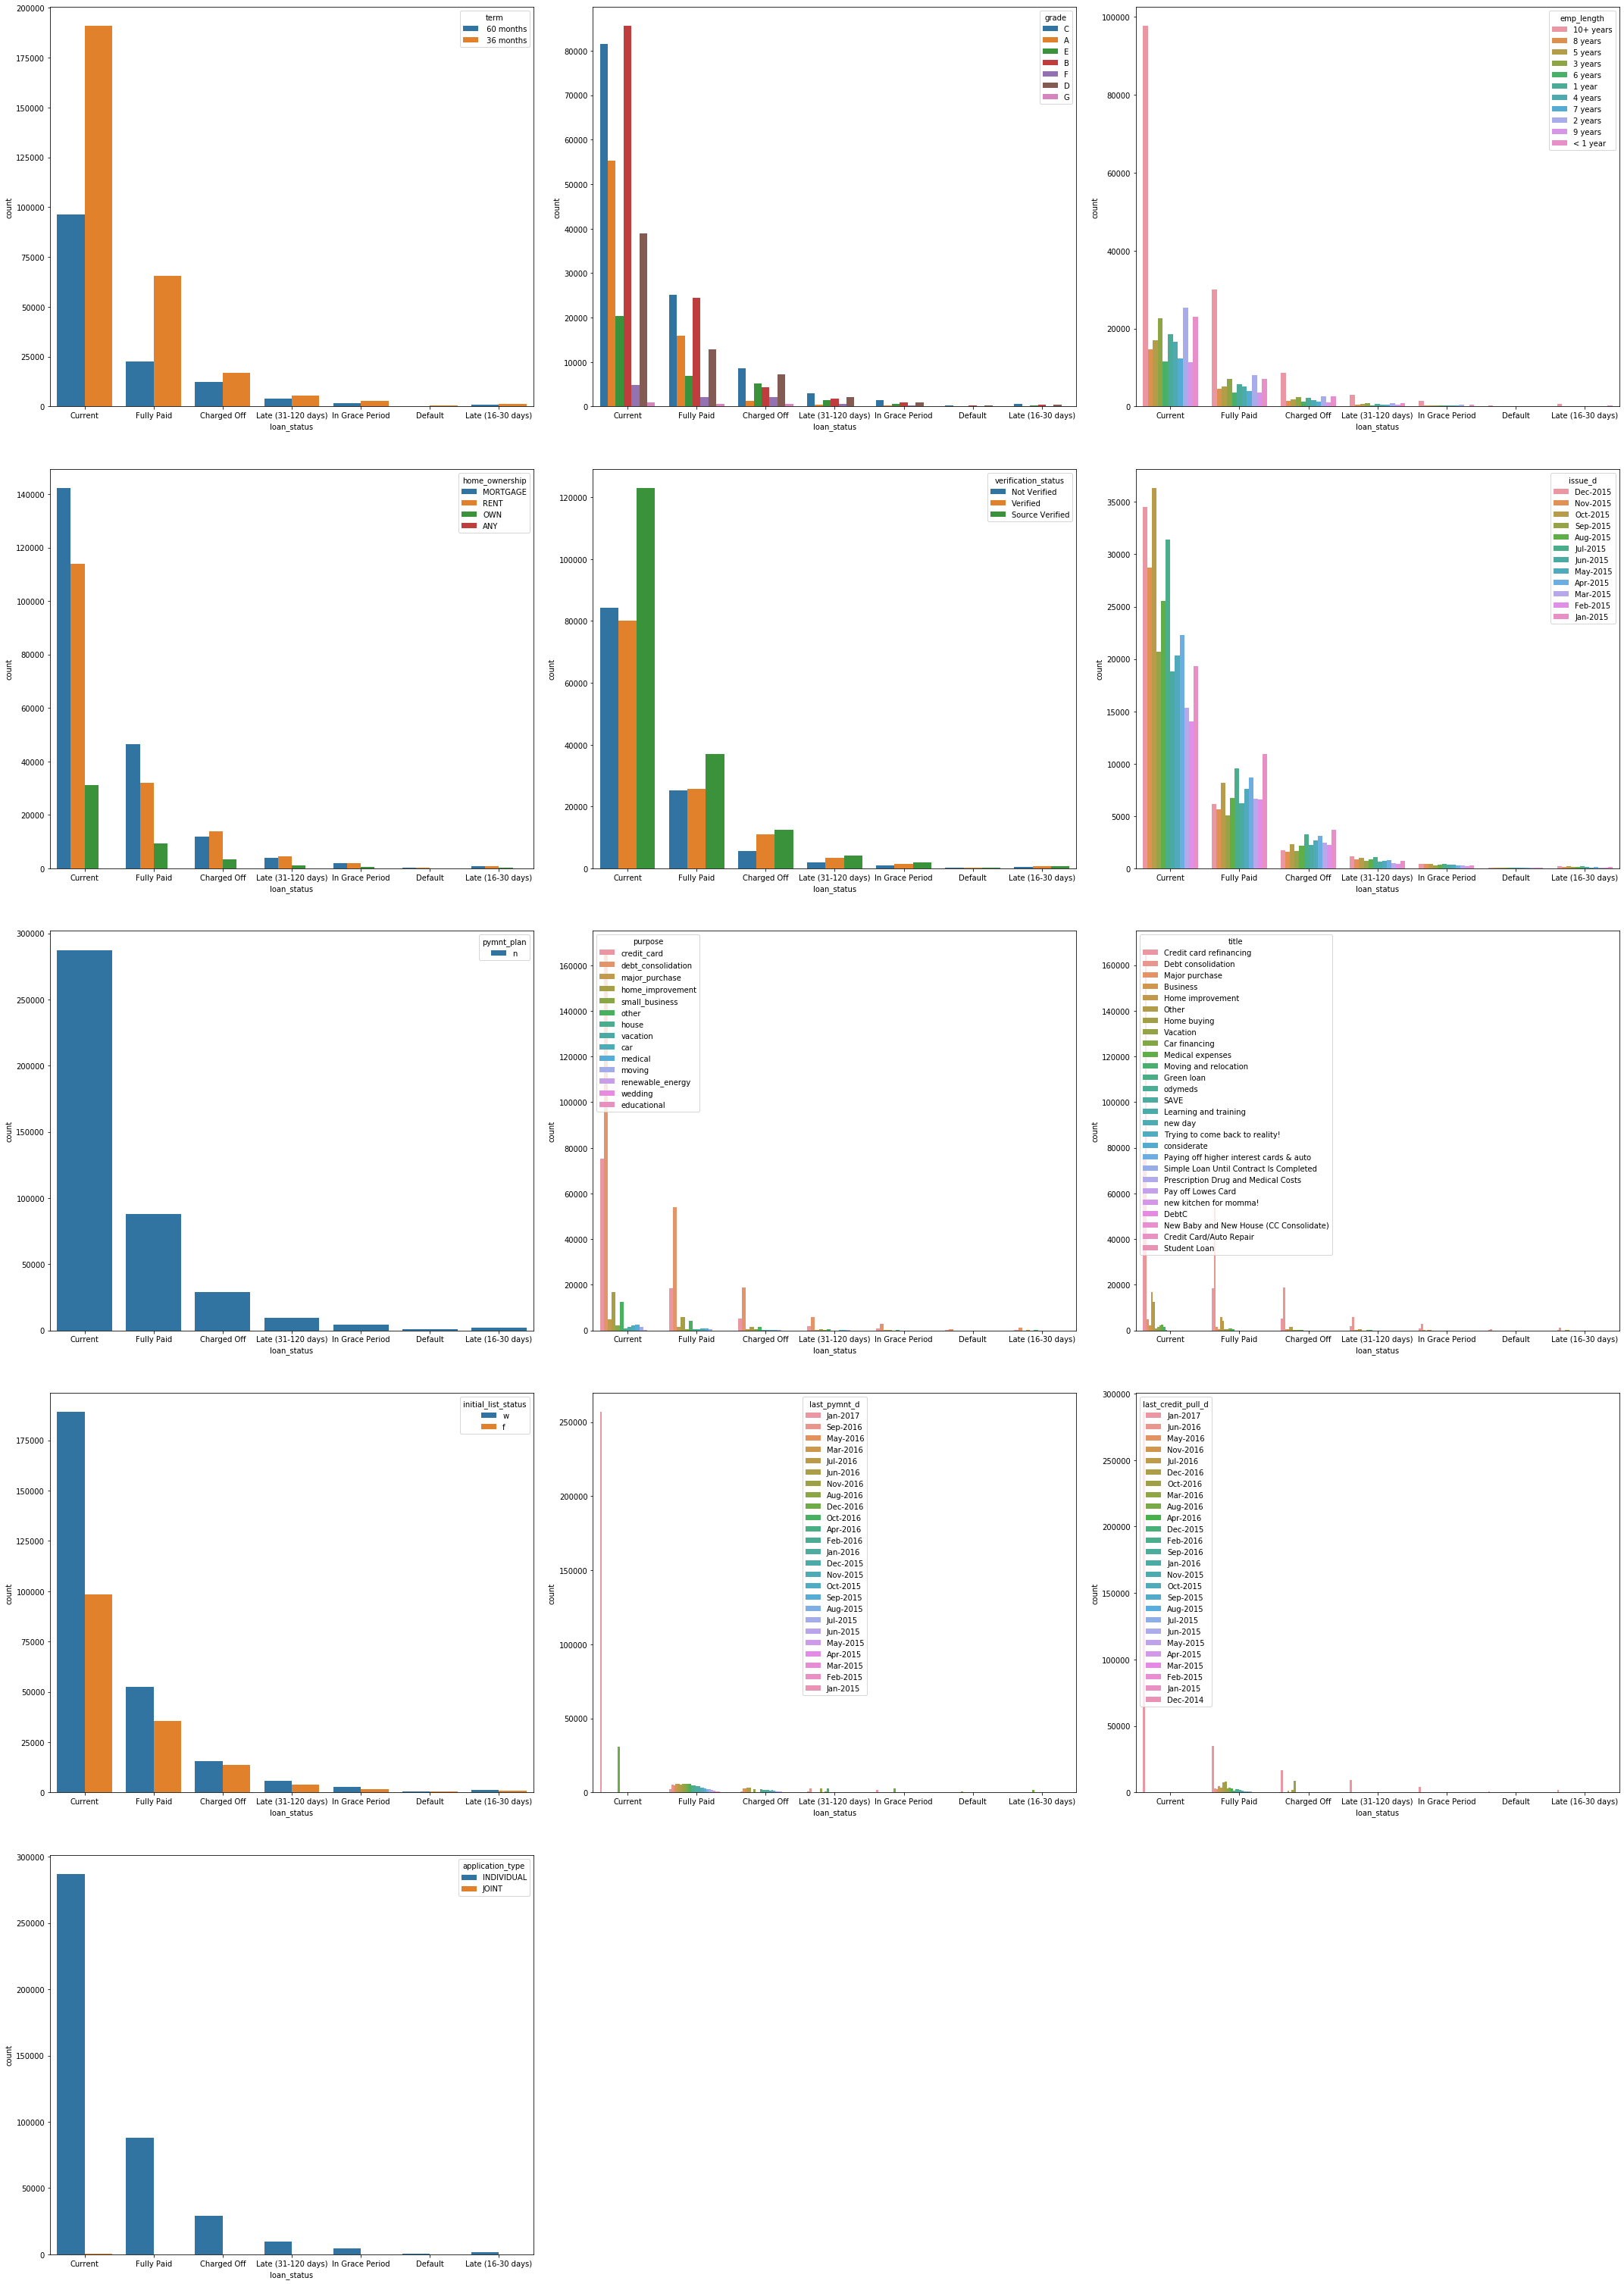

In [234]:
#can we eliminate any categorical features?
df = pd.concat([y2015['loan_status'],y2015[col]],axis = 1)                                   

x=1
import seaborn as sns
plt.figure(figsize=(30,50))
for i in col:
    plt.subplot(len(col)/3+2,3,x)
    sns.countplot(x = 'loan_status',hue = i, data=df)
    x+=1
plt.tight_layout()
plt.show()

In [235]:
#drop variables with little effect on loan status
drop = ['issue_d','pymnt_plan','application_type']
categorical.drop(drop,axis=1,inplace = True)

In [236]:
categorical_dummies = pd.get_dummies(categorical,drop_first=True)

In [264]:
print('number of features:', len(categorical.columns) + len(X.T))

number of features: 33


In [192]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = pd.concat([X,categorical_dummies],axis =1 )
Y = pd.get_dummies(y2015.loan_status,drop_first = True)


In [197]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,last_credit_pull_d_Mar-2016,last_credit_pull_d_May-2015,last_credit_pull_d_May-2016,last_credit_pull_d_Nov-2015,last_credit_pull_d_Nov-2016,last_credit_pull_d_Oct-2015,last_credit_pull_d_Oct-2016,last_credit_pull_d_Sep-2015,last_credit_pull_d_Sep-2016,last_credit_pull_d_no value
0,-2.299707,-0.224798,-2.553031,-1.588402,-2.736453,2.117097,-1.432500,-0.665209,-1.184474,-0.368317,...,0,0,0,0,0,0,0,0,0,0
1,0.191804,-0.641772,2.539935,-0.531676,0.706610,1.234011,-1.638183,1.615854,1.738772,0.352064,...,0,0,0,0,0,0,0,0,0,0
2,-0.134827,0.600869,-0.207785,-1.437983,-1.271107,0.379144,2.765212,-1.588258,-1.656194,-1.223623,...,0,0,0,0,0,0,0,0,0,0
3,1.966946,-5.123898,-0.972719,0.768490,-0.802631,0.299011,0.470542,-0.214199,0.164311,0.211975,...,0,0,0,0,0,0,0,0,0,0
4,-3.768882,-0.902805,-1.140055,-0.029950,-0.701050,0.403457,-0.889833,0.506869,0.051592,-1.158906,...,0,0,0,0,0,0,0,0,0,0


In [262]:
from sklearn.model_selection import cross_val_score, GridSearchCV

X_train, X_test , y_train , y_test = train_test_split(X,Y)

n_estimators = np.arange(10,60,10)
max_features = np.arange(1,25,5)
max_depth = np.arange(5,55,5)

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               }
print(random_grid)



{'n_estimators': array([10, 20, 30, 40, 50]), 'max_features': array([ 1,  6, 11, 16, 21]), 'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()
rfgs = RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter = 3, cv = 10)

search = rfgs.fit(X_train,y_train)


In [ ]:
search.best_score_